# Load data

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

f = np.load(str(Path('../data/features_(n_iterations, n_wells, n_dates, n_features).npy')))
t = np.load(str(Path('../data/targets_(n_iterations, n_wells, n_dates).npy')))

n_iterations, n_wells, n_dates, n_features = f.shape
assert t.shape == (n_iterations, n_wells, n_dates)

print(f.shape)
print(t.shape)

assert np.isnan(t).sum() == 0
print(np.isnan(f).sum() / np.prod(f.shape) * 100, '%')

(429, 10, 114, 3)
(429, 10, 114)
15.263157894736842 %


# Count NaNs

In [4]:
def get_well(f, t, well):
    well_t = t[:, well, :]
    well_f = f[:, well, :, :]
    well_f = well_f.reshape((-1, 3))
    well_t = well_t.reshape(-1)
    return well_f, well_t


def first_true_index(arr):
    for i in range(len(arr)):
        if arr[i]:
            return i
    return len(arr)


for well in range(10):
    well_f, well_t = get_well(f, t, well)
    nan_pct = np.isnan(well_f).sum() / np.prod(well_f.shape) * 100
    is_nan = (np.isnan(well_f).sum(axis=1) >= 1)
    first_not_nan = first_true_index(~is_nan) / well_f.shape[0] * 100
    print(f'well={well}: {nan_pct:.1f}% NaN; First not NaN at {first_not_nan:.3f}%')

well=0: 89.5% NaN; First not NaN at 0.184%
well=1: 0.0% NaN; First not NaN at 0.000%
well=2: 0.0% NaN; First not NaN at 0.000%
well=3: 0.0% NaN; First not NaN at 0.000%
well=4: 5.3% NaN; First not NaN at 0.012%
well=5: 5.3% NaN; First not NaN at 0.012%
well=6: 15.8% NaN; First not NaN at 0.012%
well=7: 10.5% NaN; First not NaN at 0.025%
well=8: 10.5% NaN; First not NaN at 0.025%
well=9: 15.8% NaN; First not NaN at 0.037%


# Fit linear regressions for each well ignoring time feature

In [5]:
def get_train_test(f, t, well, train_size=0.7):
    well_f, well_t = get_well(f, t, well)

    # fill NaNs
    well_f = pd.DataFrame(well_f).bfill().ffill().values

    x_train, x_test, y_train, y_test = train_test_split(well_f, well_t, train_size=train_size, random_state=0)
    return x_train, x_test, y_train, y_test

In [6]:
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [7]:
alphas = np.geomspace(1e-5, 1e5, 100)
models = [LinearRegression(), RidgeCV(alphas=alphas), LassoCV(alphas=alphas)]
scaler = StandardScaler()

models_names = [model.__class__.__name__ for model in models]
models_rmse_names = [f'{model_name} RMSE' for model_name in models_names]
models_intercept = [f'{model_name} INTERCEPT' for model_name in models_names]
models_coef = [f'{model_name} COEF' for model_name in models_names]
models_alpha = [f'{model_name} ALPHA' for model_name in models_names if model_name != 'LinearRegression']
columns = ['well', 'n_observations', 'const PRED', 'const RMSE'] + models_rmse_names + models_intercept + models_coef + models_alpha

results = pd.DataFrame(columns=columns).set_index('well')

for well in range(10):
    x_train, x_test, y_train, y_test = get_train_test(f, t, well)

    const_prediction = y_train.mean()
    const_rmse = mean_squared_error(np.full_like(y_test, const_prediction), y_test, squared=False)

    models_rmse = []
    models_intercept = []
    models_coef = []
    models_alpha = []

    for model in models:
        model.fit(scaler.fit_transform(x_train), y_train)
        rmse = mean_squared_error(model.predict(scaler.transform(x_test)), y_test, squared=False)
        models_rmse.append(rmse)
        models_intercept.append(model.intercept_)
        models_coef.append(model.coef_)
        if not isinstance(model, LinearRegression):
            models_alpha.append(model.alpha_)

    results.loc[well] = [x_train.shape[0], const_prediction, const_rmse] + models_rmse + models_intercept + models_coef + models_alpha
results

,n_observations,const PRED,const RMSE,LinearRegression RMSE,RidgeCV RMSE,LassoCV RMSE,LinearRegression INTERCEPT,RidgeCV INTERCEPT,LassoCV INTERCEPT,LinearRegression COEF,RidgeCV COEF,LassoCV COEF,RidgeCV ALPHA,LassoCV ALPHA
well,,,,,,,,,,,,,,
0,34234,0.500918,2.998539,2.981964,2.981960,2.981964,0.500918,0.500918,0.500918,"[-0.23506086368824908, 0.0, -0.2099226644914552]","[-0.23354029345021426, 0.0, -0.20858726097436694]","[-0.2350515128064897, 0.0, -0.20991331189816176]",236.448941,0.000010
1,34234,6.463862,5.024301,3.596286,3.596309,3.596285,6.463862,6.463862,6.463862,"[1.7914484249372584, -0.058868351956775936, 1....","[1.7907074305837583, -0.05918968455076801, 1.8...","[1.791616410811122, -0.058841576642061584, 1.8...",29.150531,0.000051
2,34234,7.695755,4.601901,3.204100,3.204098,3.204100,7.695755,7.695755,7.695755,"[1.7187185088061048, -0.1436125295275052, 1.78...","[1.718016330653155, -0.14346033859187646, 1.78...","[1.718729861172503, -0.1436022596458915, 1.789...",29.150531,0.000010
3,34234,8.051013,4.883879,3.416496,3.416492,3.416496,8.051013,8.051013,8.051013,"[1.8884594094048994, -0.07585002470507024, 1.7...","[1.8872890821212147, -0.07615177339522994, 1.7...","[1.8885852718960443, -0.07565095993664478, 1.7...",29.150531,0.000260
4,34234,6.728756,4.621981,4.202569,4.202600,4.202569,6.728756,6.728756,6.728756,"[1.0947011064785475, 0.09651729815874177, 0.94...","[1.0916143962140197, 0.09576420035115696, 0.94...","[1.0946673549026895, 0.09642456929240446, 0.94...",117.681195,0.000081
5,34234,5.443310,5.479867,5.064390,5.064359,5.064383,5.443310,5.443310,5.443310,"[1.0902554164959775, 1.043825740522677, 0.9446...","[1.087582589446627, 1.0407155902697562, 0.9428...","[1.089836379927404, 1.0432575545272889, 0.9442...",117.681195,0.000658
6,34234,3.193271,2.842239,2.808244,2.808244,2.808243,3.193271,3.193271,3.193271,"[0.1810165927956606, 0.2263391923949405, 0.235...","[0.18054371734777774, 0.22316563337330936, 0.2...","[0.18054414755848852, 0.22548747652291415, 0.2...",475.081016,0.000830
7,34234,5.676931,4.376917,3.708355,3.708347,3.708354,5.676931,5.676931,5.676931,"[1.296163623569839, 0.48693504609373106, 1.280...","[1.295278833379438, 0.48632960846265627, 1.279...","[1.296125570942752, 0.48679674155034186, 1.280...",36.783798,0.000129
8,34234,6.915827,5.235305,4.204916,4.204903,4.204918,6.915827,6.915827,6.915827,"[1.6987490171163586, 0.758105674297957, 1.7343...","[1.6978697389581308, 0.7575137846358517, 1.733...","[1.6985970343528534, 0.7577909016813789, 1.734...",29.150531,0.000327


# Construct DataFrame for baseline methods

Add well number and time as features

In [8]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def construct_df(f, t):
    for iteration in range(f.shape[0]):
        for well in range(n_wells):
            f[iteration, well, :, :] = pd.DataFrame(f[iteration, well, :, :]).bfill().ffill().values
    f = np.concatenate(
        [np.concatenate([f[:, well, time, :], [[well, time]] * f.shape[0]], axis=1) for well in range(n_wells) for time in range(n_dates)],
        axis=0, dtype=float
    )
    t = np.concatenate([t[:, well, time] for well in range(n_wells) for time in range(n_dates)], axis=0, dtype=float)
    f = pd.DataFrame(f, columns=['oilrate', 'watrate', 'gasrate', 'well', 'time'])
    f['well'] = pd.Categorical(f['well'].astype(int))
    f['time'] = pd.Categorical(f['time'].astype(int))
    return f, t


X, y = construct_df(f, t)
assert X.shape[0] == y.shape[0]
print(f'{X.shape[0]} observations')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

489060 observations


# Constant prediction

In [9]:
const_prediction = y_train.mean()
const_rmse = rmse(np.full_like(y_test, const_prediction), y_test)
print(f'Const prediction: {const_prediction}\nConst RMSE: {const_rmse}')

Const prediction: 5.743135090336185
Const RMSE: 5.250765282152894


# Transform features

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_columns = ['oilrate', 'watrate', 'gasrate']
categorical_columns = ['well', 'time']
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), numerical_columns),
    ('ohe', OneHotEncoder(), categorical_columns)
])

X_train_transformed = column_transformer.fit_transform(X_train)
categorical_columns_ohe = column_transformer.transformers_[1][1].get_feature_names_out().tolist()
transformed_columns = numerical_columns + categorical_columns_ohe
X_train_transformed = pd.DataFrame(X_train_transformed.toarray(), columns=transformed_columns)
X_test_transformed = pd.DataFrame(column_transformer.transform(X_test).toarray(), columns=transformed_columns)

# Linear regressions

Number of features: 127
LinearRegression: RMSE=3.8391664873121014


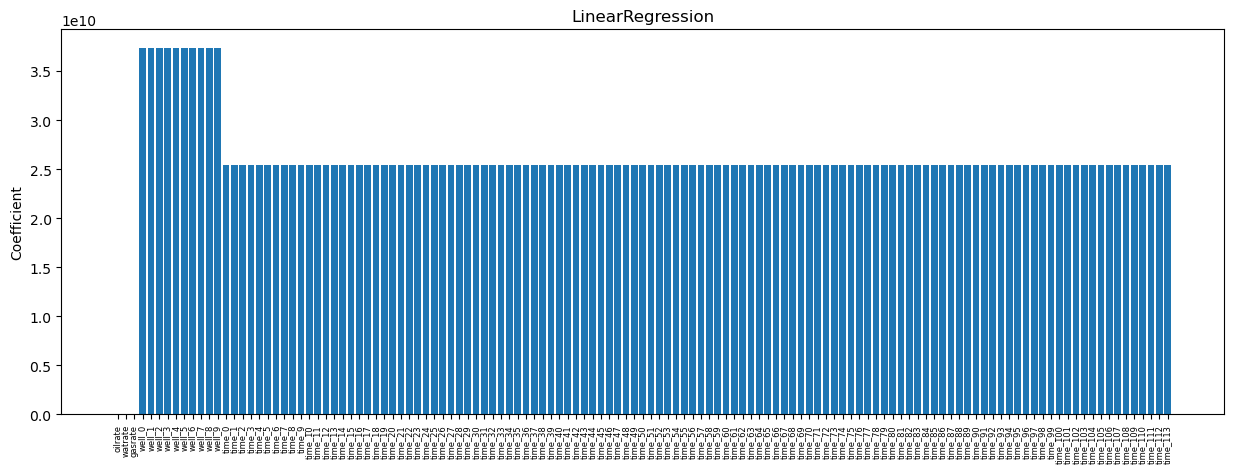

RidgeCV: RMSE=3.839161047584214
alpha=2.782559402207126


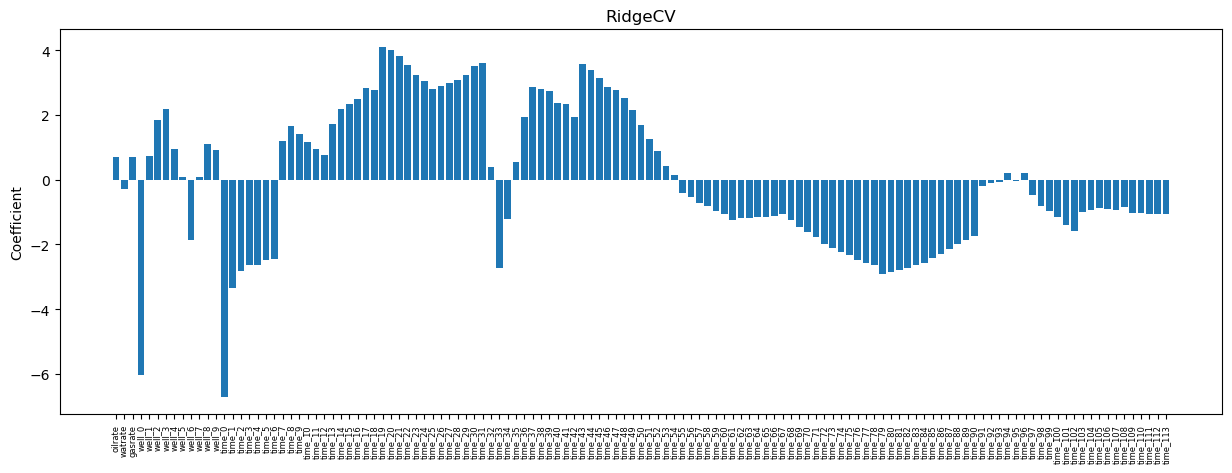

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV

alphas = np.geomspace(1e-5, 1e2, 10)
linear_models = [LinearRegression(), RidgeCV(alphas=alphas)]

print(f'Number of features: {X_test_transformed.shape[1]}')
for model in linear_models:
    model.fit(X_train_transformed, y_train)
    score = rmse(y_test, model.predict(X_test_transformed))
    model_name = model.__class__.__name__
    print(f'{model_name}: RMSE={score}')
    if not isinstance(model, LinearRegression):
        print(f'alpha={model.alpha_}')
    plt.figure(figsize=(15, 5))
    plt.bar(transformed_columns, model.coef_)
    plt.xticks(rotation=90, fontsize=6)
    plt.title(model_name)
    plt.ylabel('Coefficient')
    plt.show()


# Tree and Random Forest

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

for model in [DecisionTreeRegressor(), RandomForestRegressor(n_estimators=10)]:
    model.fit(X_train_transformed, y_train)
    score = rmse(y_test, model.predict(X_test_transformed))
    print(f'{model.__class__.__name__} RMSE={score}')

DecisionTreeRegressor RMSE=3.545901430551799
RandomForestRegressor RMSE=2.735495248492927


# CatBoost

In [13]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, cat_features=categorical_columns)
model.fit(X_train, y_train)
score = rmse(y_test, model.predict(X_test))
print(f'RMSE={score}')

D:\anaconda3\envs\invest\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


RMSE=2.4257923413280578
